In [1]:
#clause d'importation
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df



# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [3]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 16s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 20s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 22s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 18s
Full model run - done in 90s


In [4]:
# Display/plot feature importance
def display_importances(importance_df):
    # Affichage des fonctionnalités importantes
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()


In [5]:
def custom_cost(y_true, y_pred):
    fn_cost = 10
    fp_cost = 1
    fn = np.sum(np.logical_and(y_true == 1, y_pred == 0))
    fp = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    score = fn * fn_cost + fp * fp_cost
    return score

In [7]:
from sklearn.impute import KNNImputer
def fillna_fun(df, target_name='TARGET', threshold=10):
    """
    fill the dataframe,
    don't  touch to the TARGET column,
    remove col with more than 1/threshold NaN values.
    """
    df_v2 = df.copy()
    target = df_v2[target_name]
    df_v2 = df_v2.drop(target_name, axis=1)

    print('Start with ', (df_v2.isna().sum() > 1 ).sum(), ' columns with NaN and ', df_v2.isna().sum().sum(), ' cells.' , sep="")
    for col in df_v2:
        if (df_v2[col].isna().sum() > (len(df_v2)/ threshold) ):
            df_v2 = df_v2.drop(col, axis=1)
    print('Now there is ', (df_v2.isna().sum() > 1 ).sum(), ' columns with NaN and ', df_v2.isna().sum().sum(), ' cells.', sep="")

    #Imputing with default parameters
    imputer = KNNImputer()

    #Reshaping to meet the dimensional requirement
    imputer.fit(df_v2)

   
    df_filled =  pd.DataFrame(imputer.transform(df_v2), columns=df_v2.columns)

    return pd.concat([df_filled, target], axis=1)


In [11]:
from sklearn.model_selection import train_test_split

df.to_csv("customer_data", index= False)

# Remplacer les valeurs infinies par NaN dans le DataFrame df
df.replace([np.inf, -np.inf], np.nan, inplace=True)       

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
    
df_fillna= fillna_fun(train_df, target_name='TARGET', threshold=10)       
 




Start with 615 columns with NaN and 63543549 cells.
Now there is 260 columns with NaN and 4148503 cells.


In [52]:
# Separate features and target variable

X = df_fillna.drop(['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index'], axis=1, errors="ignore")
y = df_fillna['TARGET']
    

# Separate features and target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
class_dist = df_fillna['TARGET'].value_counts()

class_0_percentage = 100 * class_dist[0] / (class_dist[0] + class_dist[1])
class_1_percentage = 100 * class_dist[1] / (class_dist[0] + class_dist[1])

print(class_dist)
print('\nClass 0: {:.2f}%'.format(class_0_percentage))
print('Class 1: {:.2f}%'.format(class_1_percentage))


0.0    282679
1.0     24824
Name: TARGET, dtype: int64

Class 0: 91.93%
Class 1: 8.07%


In [34]:
from imblearn.over_sampling import RandomOverSampler


print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  

ros = RandomOverSampler(sampling_strategy=0.5, random_state=100)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train.ravel())

  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, counts of label '1': 19772
Before OverSampling, counts of label '0': 226230 

After OverSampling, the shape of train_X: (339345, 440)
After OverSampling, the shape of train_y: (339345,) 

After OverSampling, counts of label '1': 113115
After OverSampling, counts of label '0': 226230


In [56]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split
import pandas as pd

# Fonction objectif pour l'optimisation multi-objectifs
def objective(trial):
    # Définition des hyperparamètres à optimiser et de leurs espaces de recherche
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5]),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 4]),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    }

    # Entraînement du modèle avec les hyperparamètres proposés par Optuna
    model = RandomForestClassifier(**params)

    # Définition des métriques à évaluer lors de la validation croisée
    scoring = {
        'auc': make_scorer(roc_auc_score),
        'score_metier': make_scorer(custom_cost, greater_is_better=False)
    }

    # Calcul des scores de validation croisée avec les métriques AUC et score métier
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)

    # Calcul des métriques moyennes sur les plis de validation croisée
    auc = cv_results['test_auc'].mean()
    score_metier = -cv_results['test_score_metier'].mean()

    # Optimisation multi-objectifs : maximisation de l'AUC et minimisation du score métier
    return auc, score_metier

# Division des données en ensembles d'entraînement et de validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
def random_forest_model(X_train_res, y_train_res, X_test, y_test) :
    # Création de l'étude Optuna
    study = optuna.create_study(directions=['maximize', 'minimize'])

    # Optimisation des hyperparamètres avec Optuna
    study.optimize(objective, n_trials=100)

    # Obtention des meilleurs essais pour chaque objectif
    best_trials = study.best_trials

    # Obtention des meilleurs hyperparamètres
    best_params = best_trials[0].params

    # Terminez l'exécution MLflow précédente si elle est active
    if mlflow.active_run():
        mlflow.end_run()

    # Démarrez une nouvelle exécution MLflow
    mlflow.start_run()

    # Enregistrez les paramètres
    mlflow.log_params(best_params)

    # Entraînement du modèle avec les meilleurs hyperparamètres pour l'AUC
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train, y_train)

    # Enregistrez le modèle
    mlflow.sklearn.log_model(best_model, "random_forest_model")

    # Prédictions sur les données de test
    y_pred = best_model.predict_proba(X_test)[:, 1]

    # Conversion des probabilités en classes prédites en utilisant un seuil optimal
    threshold = 0.5  # Seuil initial
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred_binary)
    score_metier = custom_cost(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)

    # Enregistrez les métriques
    mlflow.log_metrics({"accuracy": accuracy, "score_metier": score_metier, "auc": auc})

    # Terminez l'exécution MLflow
    mlflow.end_run()
    return accuracy, score_metier, auc

In [57]:
accuracy_rf,score_metier_rf,auc_rf = random_forest_model(X_train_res, y_train_res, X_test, y_test)

[I 2023-07-11 22:26:30,683] A new study created in memory with name: no-name-eba74c2a-626d-4ed9-aaf2-327576410d0e
[I 2023-07-11 22:28:29,686] Trial 0 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. 
[I 2023-07-11 22:29:44,020] Trial 1 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
[I 2023-07-11 22:31:40,537] Trial 2 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto'}. 
[I 2023-07-11 22:32:17,057] Trial 3 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto'}. 
[I 2023-07-11 22:34:13,523] Trial 4 finished with values: [0.5, 115342.0] and param

[I 2023-07-11 23:24:13,613] Trial 41 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto'}. 
[I 2023-07-11 23:26:16,077] Trial 42 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
[I 2023-07-11 23:26:53,419] Trial 43 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
[I 2023-07-11 23:28:08,967] Trial 44 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
[I 2023-07-11 23:30:06,542] Trial 45 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': '

[I 2023-07-12 00:20:50,757] Trial 82 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. 
[I 2023-07-12 00:22:02,460] Trial 83 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto'}. 
[I 2023-07-12 00:23:01,482] Trial 84 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto'}. 
[I 2023-07-12 00:24:00,348] Trial 85 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
[I 2023-07-12 00:25:55,597] Trial 86 finished with values: [0.5, 115342.0] and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'a

In [74]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
   
     
    if stratified:
        cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    else:
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
         
    print("Starting LightGBM. Train shape: {}, test shape: {}".format( X_train.shape, X_test.shape))


    # Paramètres initiaux du modèle LGBM avec la métrique 'auc'
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }

    # Définition des hyperparamètres à optimiser et de leurs valeurs possibles
    param_grid = {
        'num_leaves': [20, 30, 40],
        'learning_rate': [0.01, 0.05, 0.1],
        'feature_fraction': [0.8, 0.9, 1.0],
        'bagging_fraction': [0.7, 0.8, 0.9]
    }

    # Fonction de coût métier pour utiliser comme métrique de score dans GridSearchCV

    # Définition de la métrique de score pour GridSearchCV
    scoring = make_scorer(custom_cost, greater_is_better=False)

    # Recherche par grille des meilleurs hyperparamètres
    grid_search = GridSearchCV(estimator=LGBMClassifier(**params),
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=cv,
                           verbose=2)
   

    # Entraînement du modèle avec les meilleurs hyperparamètres
    grid_search.fit( X_train, y_train)

    # Obtention du meilleur modèle
    best_model = grid_search.best_estimator_
    
    with open('modele_lightgbm.pkl', 'wb') as f:
        pickle.dump( best_model, f)
    
    
    # Obtention de l'importance des fonctionnalités
    feature_importance = best_model.feature_importances_
    feature_names = X_train.columns
    
    # Création d'un DataFrame pour stocker les fonctionnalités et leur importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Tri du DataFrame par importance décroissante
    importance_df = importance_df.sort_values('Importance', ascending=False).head(10)
    display_importances(importance_df)
    
    # Prédictions sur les données de test
    y_pred = best_model.predict_proba(X_test)[:, 1]

    # Conversion des probabilités en classes prédites en utilisant un seuil optimal
    threshold = 0.5  # Seuil initial
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    print("Meilleurs hyperparamètres:", grid_search.best_params_)

    # Calcul des métriques AUC, accuracy et score métier
    accuracy = accuracy_score(y_test, y_pred_binary)
    print("Accuracy:", accuracy)
    score_metier = custom_cost(y_test, y_pred_binary)
    print("Score métier:", score_metier)
    auc = roc_auc_score(y_test, y_pred)
    # Affichage des résultats
    print("AUC:", auc)
      
    
    return importance_df,accuracy,score_metier,auc
    

    


Starting LightGBM. Train shape: (246005, 795), test shape: (61502, 795)
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.01, num_leaves=20; total time=  23.8s
[CV] END bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.01, num_leaves=20; total time=  22.2s
[CV] END bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.01, num_leaves=20; total time=  20.7s
[CV] END bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.01, num_leaves=20; total time=  21.2s
[CV] END bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.01, num_leaves=20; total time=  20.8s
[CV] END bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.01, num_leaves=30; total time=  25.9s
[CV] END bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.01, num_leaves=30; total time=  25.2s
[CV] END bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.01, num_leaves=30; total time=  24.3s
[CV] END b

[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=20; total time=  21.1s
[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=20; total time=  21.9s
[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=20; total time=  21.7s
[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=20; total time=  22.4s
[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=30; total time=  23.6s
[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=30; total time=  23.5s
[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=30; total time=  22.9s
[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=30; total time=  22.7s
[CV] END bagging_fraction=0.7, feature_fraction=0.9, learning_rate=0.1, num_leaves=30; total time=  22.8s
[CV] END bagging_fraction=0.7, feature_fractio

[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=20; total time=  21.6s
[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=20; total time=  22.0s
[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=30; total time=  25.2s
[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=30; total time=  24.8s
[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=30; total time=  24.8s
[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=30; total time=  24.5s
[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=30; total time=  24.9s
[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=40; total time=  27.2s
[CV] END bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.05, num_leaves=40; total time=  27.0s
[CV] END bagging_fraction=0.8, featur

[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=30; total time=  29.9s
[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=30; total time=  30.4s
[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=30; total time=  32.8s
[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=30; total time=  30.1s
[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=30; total time=  30.3s
[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=40; total time=  33.8s
[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=40; total time=  34.2s
[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=40; total time=  34.2s
[CV] END bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.01, num_leaves=40; total time=  33.8s
[CV] END bagging_fraction=0.8, featur

[CV] END bagging_fraction=0.9, feature_fraction=0.8, learning_rate=0.1, num_leaves=30; total time=  25.3s
[CV] END bagging_fraction=0.9, feature_fraction=0.8, learning_rate=0.1, num_leaves=30; total time=  24.5s
[CV] END bagging_fraction=0.9, feature_fraction=0.8, learning_rate=0.1, num_leaves=30; total time=  24.5s
[CV] END bagging_fraction=0.9, feature_fraction=0.8, learning_rate=0.1, num_leaves=40; total time=  27.1s
[CV] END bagging_fraction=0.9, feature_fraction=0.8, learning_rate=0.1, num_leaves=40; total time=  27.5s
[CV] END bagging_fraction=0.9, feature_fraction=0.8, learning_rate=0.1, num_leaves=40; total time=  27.3s
[CV] END bagging_fraction=0.9, feature_fraction=0.8, learning_rate=0.1, num_leaves=40; total time=  27.0s
[CV] END bagging_fraction=0.9, feature_fraction=0.8, learning_rate=0.1, num_leaves=40; total time=  27.5s
[CV] END bagging_fraction=0.9, feature_fraction=0.9, learning_rate=0.01, num_leaves=20; total time=  26.4s
[CV] END bagging_fraction=0.9, feature_fracti

[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.05, num_leaves=30; total time=  31.4s
[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.05, num_leaves=40; total time=  34.8s
[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.05, num_leaves=40; total time=  34.6s
[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.05, num_leaves=40; total time=  35.0s
[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.05, num_leaves=40; total time=  34.8s
[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.05, num_leaves=40; total time=  35.2s
[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.1, num_leaves=20; total time=  25.3s
[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.1, num_leaves=20; total time=  25.1s
[CV] END bagging_fraction=0.9, feature_fraction=1.0, learning_rate=0.1, num_leaves=20; total time=  26.1s
[CV] END bagging_fraction=0.9, feature_f

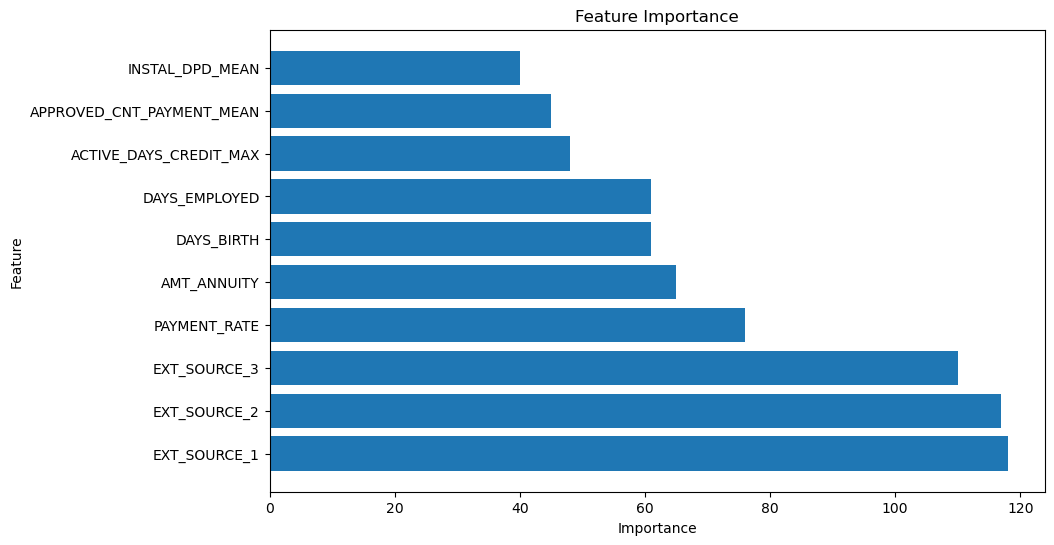

Meilleurs hyperparamètres: {'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'learning_rate': 0.1, 'num_leaves': 40}
Accuracy: 0.9187831290039349
Score métier: 48150
AUC: 0.7783389507698268
Full model run - done in 10934s


In [76]:
with timer("Full model run"):
    importance_df,accuracy,score_metier,auc=kfold_lightgbm(df, 5, stratified = False, debug= False)        

In [3]:
import pickle
with open('modele_lightgbm.pkl', 'rb') as f:
    model_lgbm = pickle.load(f)
    print("modéle load ok")

modéle load ok


In [13]:
with open('df_test.pkl', 'wb') as f:
    pickle.dump(test_df, f)


In [66]:
from sklearn.linear_model import LogisticRegression
# Fonction objectif pour l'optimisation multi-objectifs
def objective1(trial):
    # Définition des hyperparamètres à optimiser et de leurs espaces de recherche
    params = {
        'C': trial.suggest_loguniform('C', 0.1, 10.0),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'none'])
         
    }

    # Entraînement du modèle avec les hyperparamètres proposés par Optuna
    model = LogisticRegression(**params)

    # Définition des métriques à évaluer lors de la validation croisée
    scoring = {
        'auc': make_scorer(roc_auc_score),
        'score_metier': make_scorer(custom_cost, greater_is_better=False)
    }

    # Calcul des scores de validation croisée avec les métriques AUC et score métier
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)

    # Calcul des métriques moyennes sur les plis de validation croisée
    auc = cv_results['test_auc'].mean()
    score_metier = -cv_results['test_score_metier'].mean()

    # Optimisation multi-objectifs : maximisation de l'AUC et minimisation du score métier
    return auc, score_metier

# Division des données en ensembles d'entraînement et de validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
def logistic_regression_model(X_train_res, y_train_res, X_test, y_test) :
    # Création de l'étude Optuna
    study = optuna.create_study(directions=['maximize', 'minimize'])

    # Optimisation des hyperparamètres avec Optuna
    study.optimize(objective1, n_trials=100)

    # Obtention des meilleurs essais pour chaque objectif
    best_trials = study.best_trials

    # Obtention des meilleurs hyperparamètres
    best_params = best_trials[0].params

    # Terminez l'exécution MLflow précédente si elle est active
    if mlflow.active_run():
        mlflow.end_run()

    # Démarrez une nouvelle exécution MLflow
    mlflow.start_run()

    # Enregistrez les paramètres
    mlflow.log_params(best_params)

    # Entraînement du modèle avec les meilleurs hyperparamètres pour l'AUC
    best_model = LogisticRegression(**best_params)
    best_model.fit(X_train, y_train)

    # Enregistrez le modèle
    mlflow.sklearn.log_model(best_model, "random_forest_model")

    # Prédictions sur les données de test
    y_pred = best_model.predict_proba(X_test)[:, 1]

    # Conversion des probabilités en classes prédites en utilisant un seuil optimal
    threshold = 0.5  # Seuil initial
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred_binary)
    score_metier = custom_cost(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)

    # Enregistrez les métriques
    mlflow.log_metrics({"accuracy": accuracy, "score_metier": score_metier, "auc": auc})

    # Terminez l'exécution MLflow
    mlflow.end_run()
    return accuracy, score_metier, auc

In [67]:
accuracy_lr, score_metier_lr, auc_lr = logistic_regression_model(X_train_res, y_train_res, X_test, y_test)

[I 2023-07-12 02:24:26,015] A new study created in memory with name: no-name-38daccce-04d6-40d2-ab7e-70707e010c3e
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-07-12 02:24:55,585] Trial 0 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 3.3677889137000907, 'penalty': 'l2'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\e

C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-07-12 02:30:10,863] Trial 12 finished with values: [0.50001755

C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-07-12 02:34:56,861] Trial 23 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 1.4482265861207932, 'penalty': 'none'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarnin

C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-07-12 02:38:28,561] Trial 31 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 5.70161563345478, 'penalty': 'none'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning:

[I 2023-07-12 02:43:12,751] Trial 42 finished with values: [0.4999915492079657, 115337.6] and parameters: {'C': 0.5125873629181018, 'penalty': 'l2'}. 
[I 2023-07-12 02:43:36,510] Trial 43 finished with values: [0.4999915492079657, 115337.6] and parameters: {'C': 0.2251211568013944, 'penalty': 'l2'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore t

C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-07-12 02:48:28,992] Trial 54 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 1.6857971478832792, 'penalty': 'none'}. 
[I 2023-07-12 02:48:55,489] Trial 55 finished with values: [0.5000218670105138, 115331.4] and parameters: {'C': 4.880591393851155, 'penalty': 'l2'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore 

C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-07-12 02:53:40,351] Trial 66 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 8.801088082561725, 'penalty': 'none'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceW

C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-07-12 02:57:11,433] Trial 74 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 0.30146339581289183, 'penalty': 'none'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:458: Convergenc

[I 2023-07-12 03:01:06,967] Trial 83 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 0.9431160259635011, 'penalty': 'none'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-07-12 03:01:33,446] Trial 84 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 4.20931107643696, 'penalty': 'l2'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-07-12 03:05:56,577] Trial 94 finished with values: [0.5000175592651878, 115331.6] and parameters: {'C': 0.9431160259635011, 'penalty': 'none'}. 
C:\Users\boudj\anaconda3\envs\env2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

In [1]:
accuracy_lr

NameError: name 'accuracy_lr' is not defined